# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [40%]

Spring 2021 semester.

Due date: **July 19th 2021.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file (exact submission guidelines will be given in the next couple of days). 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display one train and one test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class] and train the model for 10 epochs.

**b)**   Now set the learning rate to 10 and retrain. Give a brief explanation to the observed results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on the CIFAR-10 training set and Visualize the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

**b)**  Give a breakdown of the number of parameters within the above model, as well as the overall number.

# ***Example Code***

In [1]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [5]:
# train and test functions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [6]:
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.432031
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.576757
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.486315
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.444516
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.324351
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.383382
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.256830
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.430398
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.351442
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.444126
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.447588
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.269341
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.249097
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.211131
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.308074
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.344421
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.370573
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.412838
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.311482
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.268119
Train Epoch:

In [7]:
# Testing
test()


Test set: Average loss: 0.2770, Accuracy: 9223/10000 (92%)



# **Answer (1):**


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    if dataset =='mnist':
        img = img*0.3081 + 0.1307 # unnormalize
    elif dataset == 'cifar10':
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
dataset = 'mnist'

data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

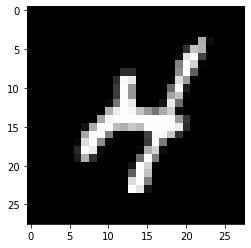

In [10]:
# get some random training images for mnist dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

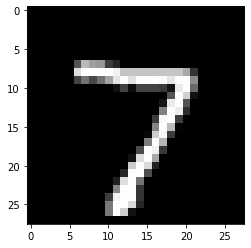

In [11]:
# get some random test images for mnist dataset
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

In [12]:
dataset = 'cifar10'

data_transform = transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


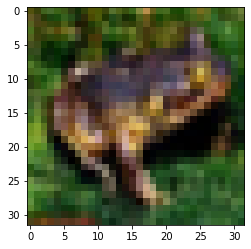

In [13]:
# get some random training images for cifar10 dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

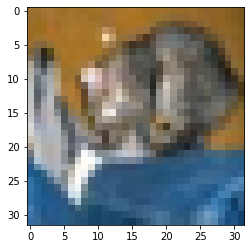

In [14]:
# get some random test images for cifar10 dataset
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

# **Answer (2):**


In [15]:
dataset = 'mnist'

data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

## (a)

In [16]:
# plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch.
def plot_network_weights(num_outputs, size):
    for m in network.modules():
        if isinstance(m, nn.Linear):           
            imshow(torchvision.utils.make_grid(m.weight.data.cpu().view(num_outputs,1,size,size),normalize=True, scale_each=True))

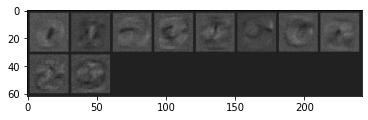

In [17]:
plot_network_weights(10,28)

## (b)

In [18]:
import torch.utils.data.sampler as samplers

class SubsetSampler(samplers.Sampler):
    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples < len(self.data_source):
            self.num_samples = num_samples
        else:
            self.num_samples = len(self.data_source)
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [19]:
examples = 50
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = False, sampler = SubsetSampler(trainset, examples), num_workers = 0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, sampler = SubsetSampler(testset, examples), num_workers = 0)

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr = lr)

In [20]:
epochs = 70
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.497602
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.281253
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.091569
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.925144
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.778587
Train Epoch: 6 [0/60000 (0%)]	Loss: 1.648560
Train Epoch: 7 [0/60000 (0%)]	Loss: 1.532374
Train Epoch: 8 [0/60000 (0%)]	Loss: 1.428071
Train Epoch: 9 [0/60000 (0%)]	Loss: 1.334170
Train Epoch: 10 [0/60000 (0%)]	Loss: 1.249454
Train Epoch: 11 [0/60000 (0%)]	Loss: 1.172873
Train Epoch: 12 [0/60000 (0%)]	Loss: 1.103496
Train Epoch: 13 [0/60000 (0%)]	Loss: 1.040497
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.983143
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.930791
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.882877
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.838908
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.798454
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.761141
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.726640
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.694668
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.6649

In [21]:
# Testing
test()


Test set: Average loss: 0.0052, Accuracy: 32/10000 (0%)



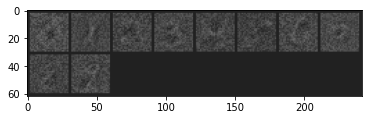

In [22]:
plot_network_weights(10,28)

# **Answer (3):**


## (a) 

In [23]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [24]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, H):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, H)
        self.fc2 = nn.Linear(H, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs) # reshape input to batch x num_inputs
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

In [25]:
#Network with 1000 hidden units and a tanh non-linearity. 
network = Net(num_inputs, num_outputs, 1000)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [26]:
#Train the model for 10 epochs
epochs = 10
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330380
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.676925
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.676380
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.436863
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.422770
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.378343
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.483535
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.345586
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.223098
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.278704
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.191411
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.296515
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.241083
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.249882
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.278695
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.315240
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.257649
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.380494
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.666147
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.395686
Train Epoch:

In [27]:
# Testing
test()


Test set: Average loss: 0.1625, Accuracy: 9529/10000 (95%)



## (b)

In [28]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False, num_workers = 0)

In [29]:
network = Net(num_inputs, num_outputs, 1000)
optimizer = optim.SGD(network.parameters(), lr=10) #The learning rate equal to 10

In [30]:
epochs = 10
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376049
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1262.185059
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1167.068726
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1128.655884
Train Epoch: 1 [25600/60000 (43%)]	Loss: 398.301453
Train Epoch: 1 [32000/60000 (53%)]	Loss: 250.957733
Train Epoch: 1 [38400/60000 (64%)]	Loss: 401.769470
Train Epoch: 1 [44800/60000 (75%)]	Loss: 469.963867
Train Epoch: 1 [51200/60000 (85%)]	Loss: 352.248688
Train Epoch: 1 [57600/60000 (96%)]	Loss: 609.857849
Train Epoch: 2 [0/60000 (0%)]	Loss: 215.119568
Train Epoch: 2 [6400/60000 (11%)]	Loss: 204.905182
Train Epoch: 2 [12800/60000 (21%)]	Loss: 250.299561
Train Epoch: 2 [19200/60000 (32%)]	Loss: 154.591644
Train Epoch: 2 [25600/60000 (43%)]	Loss: 372.659119
Train Epoch: 2 [32000/60000 (53%)]	Loss: 209.447418
Train Epoch: 2 [38400/60000 (64%)]	Loss: 379.861603
Train Epoch: 2 [44800/60000 (75%)]	Loss: 290.590790
Train Epoch: 2 [51200/60000 (85%)]	Loss: 103.961754
Train Epoch: 2 [57600/6

In [31]:
# Testing
test()


Test set: Average loss: 253.7118, Accuracy: 6164/10000 (62%)



# **Answer (4):**


## (a)

In [32]:
dataset = 'cifar10'

data_transform = transforms.Compose([ transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(iter(train_loader).next()[0].size()[1], 16, 5)
        self.pool = nn.MaxPool2d(2, 2) # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(16, 128, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(128 * 5 * 5, 64) # 5*5 from image dimension
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

# num_channels = iter(train_loader).next()[0].size()[1]
network = Net()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [34]:
# Train it for 20 epochs on the CIFAR-10 training set.
epochs = 20
# Training
for i in range(1, epochs+1):
  train(i)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.315946
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.155160
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.022368
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.972038
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.856323
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.876755
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.813987
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.908056
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.834236
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.806534
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.767508
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.766748
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.635646
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.706876
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.820709
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.633419
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.611942
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.605662
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.461184
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.440497
Train Epoch: 3 [25

In [35]:
# Testing
test()


Test set: Average loss: 0.9584, Accuracy: 6687/10000 (67%)



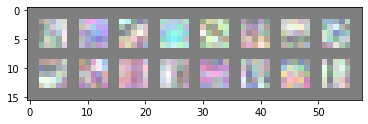

In [36]:
# Visualize the first layer filters.
for x in network.modules():
    if isinstance(x, nn.Conv2d):
        imshow(torchvision.utils.make_grid(x.weight.data.cpu(),normalize=True, scale_each=True))
        break

## (b)

In [46]:
#Explanation in report
overall_parameters = 0
for p in network.parameters():
    count = np.prod(p.size())
    overall_parameters += count
print("The overall number of parameters:", overall_parameters)

The overall number of parameters: 258058
